# Practica 2: Procesamientos de imagenes y video

La pr&aacute;ctica se basa en grabar a una persona al volante con el motor apagado, a la altura de los ojos. El conductor debe alternar su mirada hacia el frente, izquierda, derecha, retrovisor y palanca.
Este proyecto tiene la finalidad de evaluar en tiempo real si detecta a la perfecci&oacute;n los PAVs gracias a los datos aprendidos.

## Librer&iacute;as Importadas

In [42]:
import pandas as pd
import numpy as np
import cv2
import sys
import os
import warnings
import mediapipe as mp
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, recall_score, confusion_matrix, accuracy_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split

En esta secci&oacute;n se empieza a definir la ruta donde estan los videos para poder extraerlos y comenzar a modelarlos dentro de un dataframe.

In [2]:
Ruta = "./Imagen/"
dir_list = os.listdir(Ruta)
dir_list.sort()
lista_csv = []
for i in dir_list:
    fnames = os.listdir(Ruta + i)
    for f in fnames:
        if f.endswith(".csv"):
            df = pd.read_csv(Ruta + i + f"/{f}")
            name = f.replace('csv', 'mp4')
            df['source'] = Ruta + i + f"/{name}"
            df['subject'] = name[:-4]
            lista_csv.append(df)

Aqu&iacute; se tratan los dataframe que vengan en formatos diferentes, es decir, los que tienen distinto orden en cuanto a la ejecuci&oacute;n de los PAVs.

In [3]:
df_last = lista_csv[-1]
dfsCsv = lista_csv[:-1]

En esta parte se empiezan a mapear los valores de los PAVs: frente, izquierda, derecha, retrovisor, palanca. De igual forma trae el inicio y fin del segmento, de donde viene y quien trajo ese dato.

In [4]:
mapeo_valores = {
    'frente': 'FRENTE',
    'izquierdo': 'IZQUIERDA',
    'central': 'RETROVISOR',
    'derecho': 'DERECHA',
    'palanca': 'PALANCA'
}

df_last['label'] = df_last['label'].map(mapeo_valores)

df_last = df_last[['inicio', 'fin', 'label', 'source', 'subject']]
df_last

,inicio,fin,label,source,subject
0,00:00,00:12,FRENTE,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT
1,00:13,00:24,IZQUIERDA,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT
2,00:25,00:35,RETROVISOR,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT
3,00:37,00:47,DERECHA,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT
4,00:48,01:00,PALANCA,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT


Se empieza a seccionar el audio para comenzar a particionar de acuerdo a donde este viendo la persona en el video.

In [5]:
dfs_concat = []
dfs_concat.append(df_last)
for df in dfsCsv:
    source = df['source'][0]
    subject = df['subject'][0]
    columns_to_keep = ['FRENTE', 'RETROVISOR', 'IZQUIERDA', 'DERECHA', 'PALANCA']
    df = df[columns_to_keep]

    # Se cambia el formato del dataframe
    df = df.melt(var_name='label', value_name='intervalo')

    df[['inicio', 'fin']] = df['intervalo'].str.split('-', expand=True)

    df.drop(columns='intervalo', inplace=True)

    df = df[['inicio', 'fin', 'label']]

    df['source'] = source
    df['subject'] = subject
    df = df.dropna(axis=0)
    dfs_concat.append(df)

Se concatenan los valores para poder crear un dataframe completo y en base a este comenzar a entrenar.

In [6]:
IMG_df = pd.concat(dfs_concat)
IMG_df.reset_index(drop=True, inplace=True)

In [7]:
# Se imprime para ver si nos trae el resultado deseado.
IMG_df

,inicio,fin,label,source,subject
0,00:00,00:12,FRENTE,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT
1,00:13,00:24,IZQUIERDA,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT
2,00:25,00:35,RETROVISOR,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT
3,00:37,00:47,DERECHA,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT
4,00:48,01:00,PALANCA,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT
5,00:00,00:08,FRENTE,./Imagen/Andres/ANDRES.mp4,ANDRES
6,00:14,00:16,FRENTE,./Imagen/Andres/ANDRES.mp4,ANDRES
7,00:22,00:23,FRENTE,./Imagen/Andres/ANDRES.mp4,ANDRES
8,00:29,00:36,FRENTE,./Imagen/Andres/ANDRES.mp4,ANDRES
9,00:24,00:28,RETROVISOR,./Imagen/Andres/ANDRES.mp4,ANDRES


En esta parte se crea la carpeta donde se van a guardar los videos recortados, se itera sobre cada fila del dataframe, se carga el video y en base a eso se obtiene la tasa de fotogramas del video. Al final se obtiene la carpeta con los videos segmentados en carpetas individuales.

In [8]:
output_folder = './sources'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for index, row in IMG_df.iterrows():
    subject = row['subject']
    inicio = row['inicio']
    fin = row['fin']
    label = row['label']
    source = row['source']
    
    video_capture = cv2.VideoCapture(source)
    
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    
    # Verifica que el formato de inicio y fin sea válido
    if ':' not in inicio or ':' not in fin:
        print(f"Error en el formato de tiempo en la fila {index}. Saltando esta fila.")
        continue
    
    # Convertir los tiempos de inicio y fin a segundos
    inicio_segundos = int(inicio.split(':')[0]) * 60 + int(inicio.split(':')[1])
    fin_segundos = int(fin.split(':')[0]) * 60 + int(fin.split(':')[1])
    
    folder_PAV = f'./sources/{label}'
    if not os.path.exists(folder_PAV):
        os.makedirs(folder_PAV)
    output_filename = f"{folder_PAV}/{subject}_{index}.mp4"
    IMG_df.at[index, 'source'] = output_filename
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_filename, fourcc, fps, (int(video_capture.get(3)), int(video_capture.get(4))))
    
    video_capture.set(cv2.CAP_PROP_POS_FRAMES, inicio_segundos * fps)
    
    while video_capture.get(cv2.CAP_PROP_POS_FRAMES) < fin_segundos * fps:
        ret, frame = video_capture.read()
        if ret:
            video_writer.write(frame)
        else:
            break

    video_capture.release()
    video_writer.release()

print("Videos guardados en la carpeta 'sources'.")

Videos guardados en la carpeta 'sources'.


Se calculan las landmarks para un mejor entendimiento de los datos.

In [9]:
def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]
    landmark_point = []
    # Keypoint
    for point in landmarks:
        landmark_x = min(int(point.x * image_width), image_width - 1)
        landmark_y = min(int(point.y * image_height), image_height - 1)
        
        landmark_point.append([landmark_x, landmark_y])

    return landmark_point

Se convierten en coordenadas relativas y se normalizan para un mejor manejo de los datos.

In [10]:
def pre_process_landmark(landmark_list):
    temp_landmark_list = copy.deepcopy(landmark_list)

    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    temp_landmark_list = list(
        itertools.chain.from_iterable(temp_landmark_list))

    max_value = max(list(map(abs, temp_landmark_list)))

    def normalize_(n):
        return n / max_value

    temp_landmark_list = list(map(normalize_, temp_landmark_list))

    return temp_landmark_list

In [14]:
def get_landmark_list(landmarks):
    landmark_list = []
    # Keypoint
    for point in landmarks:
        landmark_list
        landmark_list.append(point.x)
        landmark_list.append(point.y)
    return landmark_list

In [15]:
def create_dataframe(temp_landmark_list, label):
    columnas = ["label"] + [f"k{i}" for i in range(12)]
    datos = [label, *temp_landmark_list]
    return pd.DataFrame([datos], columns=columnas)

En base a lo recabado anteriormente, se comienzan a crear un dataframe con todos los keypoints de todos los videos para que el entrenamiento sea lo mas confiable posible.

In [16]:
mp_face_detection = mp.solutions.face_detection

dfs_concat = []
for index, row in IMG_df.iterrows():
    video_path = row['source']
    label = row['label']
    
    cap = cv2.VideoCapture(video_path)
    detections_data = []

    if not cap.isOpened():
        print(f"Error al abrir el video {video_path}")
        continue  # Continúa con el siguiente video si no se puede abrir este
    
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        while True:
            success, image = cap.read()
            if not success:
                print("Fin del video.")  # Indica el fin del video y sale del bucle
                break

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            results = face_detection.process(image)

            if results.detections:
                for detection in results.detections:
                    relative_keypoints = detection.location_data.relative_keypoints
                    landmark_list = get_landmark_list(relative_keypoints)
                    df = create_dataframe(landmark_list, label)
                    dfs_concat.append(df)

keypoint_df = pd.concat(dfs_concat)

Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.


In [17]:
keypoint_df

,label,k0,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11
0,FRENTE,0.364167,0.464893,0.587562,0.455941,0.462640,0.525156,0.477081,0.594093,0.281246,0.510553,0.752550,0.491438
0,FRENTE,0.365448,0.465282,0.587148,0.455919,0.464549,0.525039,0.478842,0.593749,0.281606,0.510677,0.749938,0.490615
0,FRENTE,0.365791,0.465853,0.588226,0.456342,0.466498,0.525945,0.480682,0.594433,0.280771,0.511338,0.750421,0.490809
0,FRENTE,0.365927,0.465907,0.587906,0.456613,0.466435,0.526683,0.480438,0.594891,0.280427,0.511140,0.749873,0.490744
0,FRENTE,0.366032,0.465785,0.588230,0.456568,0.466819,0.526718,0.480658,0.595000,0.279931,0.511214,0.749829,0.490816
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,PALANCA,0.504318,0.373015,0.580617,0.344577,0.534926,0.441311,0.548123,0.503525,0.491974,0.408892,0.656242,0.352880
0,PALANCA,0.504573,0.373296,0.580625,0.343828,0.534910,0.441135,0.548593,0.503470,0.492990,0.409620,0.657238,0.350906
0,PALANCA,0.504128,0.371230,0.581019,0.343525,0.535348,0.442825,0.548439,0.505153,0.490908,0.405956,0.656863,0.350400
0,PALANCA,0.503724,0.370829,0.581127,0.343166,0.535256,0.441919,0.548018,0.504910,0.489886,0.407245,0.656608,0.352155


## Evaluaci&oacute;n del mejor modelo

Se traen las caracteristicas que se quieren utilizar, definimos cual sera nuestra Y y Z

In [28]:
keypoints_df = keypoint_df[['label', 'k0', 'k1', 'k2', 'k3', 'k4', 'k5','k6', 'k7',	'k8', 'k9',	'k10', 'k11']]

In [30]:
X = keypoint_df.iloc[:, 1:]
Y = keypoint_df.iloc[:, 0]

In [31]:
encoder = LabelEncoder()
y_encode = encoder.fit_transform(Y)

In [32]:
y_encode

array([1, 1, 1, ..., 3, 3, 3])

In [33]:
names = [
    "Nearest Neighbors",
    "Naive Bayes",
    "Linear SVM",
]
modelos = [
    KNeighborsClassifier(n_neighbors=6),
    GaussianNB(),
    SVC(kernel='linear')
]

Se hace la validacion cruzada utilizando tambien los modelos como Naive Bayes, Supported Vector Machines y Nearest Neighbors, para ver a cual de los 3 le va mejor.

In [40]:
def validacion_cruzada(model, X, y):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    precision_scores = []
    recall_scores = []
    f1_scores = []
    accuracies = []

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        X_test_np = X_test.values
        y_pred = model.predict(X_test_np)

        precision = precision_score(y_test, y_pred, average='weighted')
        precision_scores.append(precision)

        recall = recall_score(y_test, y_pred, average='weighted')
        recall_scores.append(recall)

        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

        accuracy = model.score(X_test, y_test)
        accuracies.append(accuracy)

    return np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores), np.mean(accuracies)

resultados = []

for nombre, modelo in zip(names, modelos):
    precision, recall, f1, accuracy = validacion_cruzada(model=modelo, X=X, y=y_encode)
    resultados.append({"nombre": nombre, "precision": precision, "recall": recall, "f1_score": f1, "accuracy": accuracy})

df_resultados = pd.DataFrame(resultados)

In [41]:
resultados = []

for nombre, modelo in zip(names, modelos):
    f1s, sensitivity, specificity, accuracy = validacion_cruzada(model=modelo,X=X, y=y_encode)
    resultados.append({"nombre": nombre, "f1_score": f1s, "sensibilidad": sensitivity, "especificidad": specificity, "precision": accuracy})

df_resultados = pd.DataFrame(resultados)

Aqui se puede ver que al que mejor le fue es a Nearest Neighborns, el cual tomaremos como mejor modelo ya que fue el que tuvo la puntuacion mas alta.

In [38]:
df_resultados

,nombre,f1_score,sensibilidad,especificidad,precision
0,Nearest Neighbors,0.952546,0.952160,0.951933,0.952160
1,Naive Bayes,0.486936,0.439763,0.449892,0.439763
2,Linear SVM,0.799451,0.774976,0.777411,0.774976


## Entrenando mejor modelo

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encode, test_size=0.2, random_state=42)
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6)

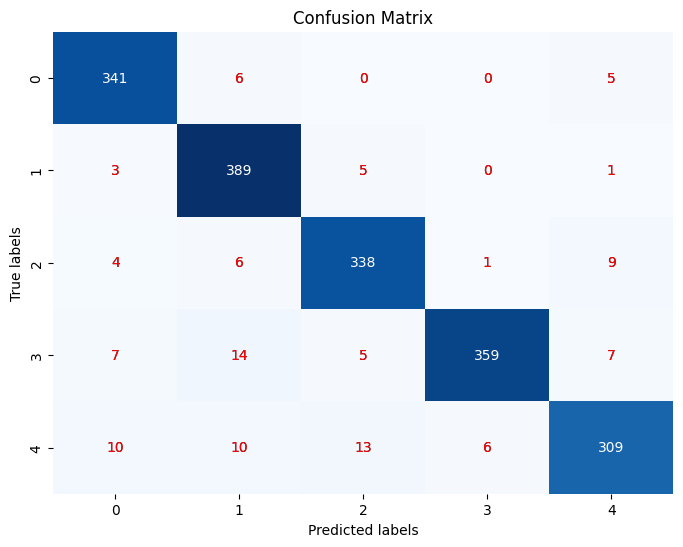

F1 Score: 0.9392291755961739
Sensibilidad (Recall): 0.9393939393939394
Especificidad por clase: [0.983957219251337, 0.9751724137931035, 0.9845637583892617, 0.9951923076923077, 0.9853333333333333]
Exactitud: 0.9393939393939394


In [44]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener predicciones del modelo
y_pred = model.predict(X_test)

# Calcular la matriz de confusión multiclase
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular métricas adicionales
f1 = f1_score(y_test, y_pred, average='weighted')
sensibilidad = recall_score(y_test, y_pred, average='weighted')
exactitud = accuracy_score(y_test, y_pred)

# Calcular especificidad para cada clase
especificidad = []
for i in range(len(conf_matrix)):
    true_negative = np.sum(np.delete(np.delete(conf_matrix, i, 0), i, 1))
    total_negative = np.sum(np.delete(conf_matrix, i, 0))
    especificidad.append(true_negative / total_negative)

# Visualizar la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)

# Resaltar los valores donde el modelo se confundió
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        if i != j:
            plt.text(j + 0.5, i + 0.5, conf_matrix[i, j], ha="center", va="center", color="red")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Imprimir métricas
print("F1 Score:", f1)
print("Sensibilidad (Recall):", sensibilidad)
print("Especificidad por clase:", especificidad)
print("Exactitud:", exactitud)

La matriz nos muestra que el modelo se confundio pero no fue tanto, teniendo resultados no perfectos pero tampoco tan malos.

## Implementando el modelo

In [45]:
import joblib
joblib.dump(model, 'modelo.pkl')

['modelo.pkl']

In [50]:
def create_dataframe(temp_landmark_list):
    columnas = [f"k{i}" for i in range(12)]
    datos = [*temp_landmark_list]
    return pd.DataFrame([datos], columns=columnas)

Aqui se prueba en vivo el modelo para deteccion de PAVs en base a los movimientos de la cabeza y ver si es muy efectivo.

In [52]:
mp_drawing = mp.solutions.drawing_utils

modelo = joblib.load('modelo.pkl')
cap = cv2.VideoCapture(0)  # Cambia '0' si tu cámara no es la predeterminada

with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Detección de rostros
        results = face_detection.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if results.detections:
            for detection in results.detections:
                mp_drawing.draw_detection(image, detection)
                relative_keypoints = detection.location_data.relative_keypoints
                landmark_list = get_landmark_list(relative_keypoints)
                X = create_dataframe(landmark_list)
                y_pred = modelo.predict(X)
                y_pred_decoded = encoder.inverse_transform([y_pred])[0]
            cv2.putText(image, y_pred_decoded, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
                
        # Muestra la imagen
        cv2.imshow('Face Detection', image)
        if cv2.waitKey(1) != -1:  # Se termina la ejecucion ante cualquier tecla presionada
            break

cap.release()
cv2.destroyAllWindows()

En conclusion, puedo decir que aunque el modelo de Nearest Neighborn fue el que tuvo una puntuacion mas alta, no clasifico bien en la mayoria de los casos.
Esto puede deberse al tratamiento de los datos por mi parte, tal vez me falto analizar mejor el como estaban organizados, como probarlos de diversa manera o quiza aumentando los datos me clasificara mejor los PAVs en tiempo real. 